In [1]:
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import warnings  # Handling warnings
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, KFold

#tuning hyperparameters
from bayes_opt import BayesianOptimization
from skopt import BayesSearchCV

# 🤐 Disable warnings to keep the code clean
warnings.filterwarnings("ignore")
# simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

# 📊 Define flags and variables
is_offline = False  # Flag for online/offline mode
is_train = True  # Flag for training mode
is_infer = True
# max_lookback = np.nan  # Maximum lookback (not specified)

# pd.set_option('display.max_rows', None)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
df = pd.read_csv("/kaggle/input/optiver-trading-at-the-close/train.csv")
# 🧹 Remove rows with missing values in the "target" column
df = df.dropna(subset=["target"])

# 🔁 Reset the index of the DataFrame and apply the changes in place
df.reset_index(drop=True, inplace=True)
df = reduce_mem_usage(df)
print("Shape of df: ", df.shape)

Mem. usage decreased to 234.78 Mb (65.4% reduction)
Shape of df:  (5237892, 17)


# Feature Engineering

In [4]:
def feature_eng(data):
    drop_cols = []
    if 'row_id' in data.columns:
        drop_cols.append('row_id')
    if 'time_id' in data.columns:
        drop_cols.append('time_id')
    df=data.drop(drop_cols, axis=1)
    df['trade_volume'] = df['bid_size'] + df['ask_size']
    df['trade_volume_diff'] = df['bid_size'] - df['ask_size']
    df['imbalance_ratio_1'] = df['imbalance_size'] / df['trade_volume']
    df['imbalance_ratio_2'] = df['imbalance_size'] / df['trade_volume_diff']
    df['imbalance_ratio_3'] = df['imbalance_size'] / df['matched_size']
    
    # stock trading price max, min, std, med
    # trading volume max, min, std, med
    # diff price vs med
    # diff trading volume vs med
    stats_cols = [
        'trade_volume', 'wap', 'reference_price', 'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price', 'ask_size'
    ]
    df_by_stock = df[stats_cols+['stock_id']].groupby('stock_id').agg(['min', 'max', 'mean', 'std'])
    df_by_stock.columns = ["_".join(x) for x in df_by_stock.columns.ravel()]
    df = df.merge(df_by_stock, on='stock_id', how='left')
    for col in [x for x in stats_cols if 'price' in x]:
        df['wap_' + col+'_'+'diff'] = df['wap']-df[col]
        df[col+'_mean_diff'] = df[col] - df[col+'_mean']
        df[col+'_mean_diff_normed'] = df[col+'_mean_diff']/df[col+'_std']
    
    for col in ['wap', 'trade_volume', 'bid_size', 'ask_size']:
        df[col +'_mean_diff'] = df[col] - df[col+'_mean']
        df[col+'_mean_diff_normed'] = df[col+'_mean_diff'] / df[col+'_std']

    # avg/diff for same day and stock
    day_cols = stats_cols + ['imbalance_size', 'matched_size']
    df_by_stock_date = df[day_cols+['stock_id','date_id']].groupby(['stock_id', 'date_id']).mean()
    df_by_stock_date.columns = [x+'_day_mean' for x in day_cols]
    fst_by_stock_date = (df[day_cols+['stock_id','date_id', 'seconds_in_bucket']]
                         .sort_values(['stock_id','date_id', 'seconds_in_bucket'])
                         .groupby(['stock_id', 'date_id']).first()
                        )
    fst_by_stock_date.columns.values[:-1] = [x+'_day_start' for x in day_cols]
    df = (df
          .merge(fst_by_stock_date, on=['stock_id','date_id'], how='left')
          .merge(df_by_stock_date, on=['stock_id','date_id'], how='left')
         )
    for col in day_cols:
        df[col+'_diff_start'] = df[col] - df[col+'_day_start']
        df[col+'_diff_day_mean'] = df[col] - df[col+'_day_mean']
    return df

In [5]:
X_train = feature_eng(df)
y_train = df['target']
X_train.drop('target', axis=1, inplace=True)

# Hyperparameter Optimization

In [6]:
# hyperparameter optimization
def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=3, random_seed=6,n_estimators=10000, output_process=False):
    # prepare data
    train_data = lgb.Dataset(data=X, label=y, free_raw_data=False)
    # parameters
    def lgb_eval(learning_rate, num_leaves, feature_fraction, bagging_fraction, max_depth, max_bin, min_data_in_leaf,min_sum_hessian_in_leaf,subsample):
        params = {'objective': 'regression', 'metric':'mae'}
        params['learning_rate'] = max(min(learning_rate, 1), 0)
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['max_bin'] = int(round(max_depth))
        params['min_data_in_leaf'] = int(round(min_data_in_leaf))
        params['min_sum_hessian_in_leaf'] = min_sum_hessian_in_leaf
        params['subsample'] = max(min(subsample, 1), 0)

        cv_result = lgb.cv(
            params, train_data, nfold=n_folds, seed=random_seed, stratified=False, metrics=['l1']
        )
        return max(cv_result['l1-mean'])

    lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.01, 1.0),
                                            'num_leaves': (24, 256),
                                            'feature_fraction': (0.1, 0.9),
                                            'bagging_fraction': (0.8, 1),
                                            'max_depth': (5, 30),
                                            'max_bin':(20,90),
                                            'min_data_in_leaf': (20, 80),
                                            'min_sum_hessian_in_leaf':(0,100),
                                           'subsample': (0.01, 1.0)}, random_state=200)


    #n_iter: How many steps of bayesian optimization you want to perform. The more steps the more likely to find a good maximum you are.
    #init_points: How many steps of random exploration you want to perform. Random exploration can help by diversifying the exploration space.

    lgbBO.maximize(init_points=init_round, n_iter=opt_round)

    model_mae=[]
    for model in range(len(lgbBO.res)):
        model_mae.append(lgbBO.res[model]['target'])

    # return best parameters
    return lgbBO.res[pd.Series(model_mae).idxmin()]['target'],lgbBO.res[pd.Series(model_mae).idxmin()]['params']

if is_train:
    opt_params = bayes_parameter_opt_lgb(
        X_train, y_train, init_round=5, opt_round=10, n_folds=3, random_seed=6, n_estimators=10000
    )
else:
    # previously saved opt_params 
    opt_params = (5.925490030320049, {'n_estimators': 1000, 'bagging_fraction': 0.8192059420307759, 'feature_fraction': 0.854792829599626, 'learning_rate': 0.8277896457253541, 'max_bin': 56, 'max_depth': 27, 'min_data_in_leaf': 55, 'min_sum_hessian_in_leaf': 45.00845042447376, 'num_leaves': 182, 'subsample': 0.4252313651032907, 'objective': 'regression', 'metric': 'mae'})

opt_params[1]["num_leaves"] = int(round(opt_params[1]["num_leaves"]))
opt_params[1]['max_depth'] = int(round(opt_params[1]['max_depth']))
opt_params[1]['min_data_in_leaf'] = int(round(opt_params[1]['min_data_in_leaf']))
opt_params[1]['max_bin'] = int(round(opt_params[1]['max_bin']))
opt_params[1]['objective']='regression'
opt_params[1]['metric']='mae'

# k fold, best model
print(opt_params)

|   iter    |  target   | baggin... | featur... | learni... |  max_bin  | max_depth | min_da... | min_su... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] bagging_fraction is set=0.9895264513703341, subsample=0.4615201756036703 will be ignored. Current value: bagging_fraction=0.9895264513703341
[LightGBM] [Warning] bagging_fraction is set=0.9895264513703341, subsample=0.4615201756036703 will be ignored. Current value: bagging_fraction=0.9895264513703341
[LightGBM] [Warning] bagging_fraction is set=0.9895264513703341, subsample=0.4615201756036703 will be ignored. Current value: bagging_fraction=0.9895264513703341
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.436654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2843
[LightGBM] [Info] Number of data points in the 

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.


[LightGBM] [Warning] bagging_fraction is set=0.9963605418316657, subsample=0.2580000042232922 will be ignored. Current value: bagging_fraction=0.9963605418316657
[LightGBM] [Warning] bagging_fraction is set=0.9963605418316657, subsample=0.2580000042232922 will be ignored. Current value: bagging_fraction=0.9963605418316657
[LightGBM] [Warning] bagging_fraction is set=0.9963605418316657, subsample=0.2580000042232922 will be ignored. Current value: bagging_fraction=0.9963605418316657
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.640314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1557
[LightGBM] [Info] Number of data points in the train set: 3491928, number of used features: 123
[LightGBM] [Warning] bagging_fraction is set=0.9963605418316657, subsample=0.2580000042232922 will be ignored. Current value: bagging_fraction=0.9963605418316657
[LightGBM] [Warning] bagging_fraction is set=0.9963605418

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.


[LightGBM] [Warning] bagging_fraction is set=0.8192059420307759, subsample=0.4252313651032907 will be ignored. Current value: bagging_fraction=0.8192059420307759
[LightGBM] [Warning] bagging_fraction is set=0.8192059420307759, subsample=0.4252313651032907 will be ignored. Current value: bagging_fraction=0.8192059420307759
[LightGBM] [Warning] bagging_fraction is set=0.8192059420307759, subsample=0.4252313651032907 will be ignored. Current value: bagging_fraction=0.8192059420307759
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.703900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3191
[LightGBM] [Info] Number of data points in the train set: 3491928, number of used features: 123
[LightGBM] [Warning] bagging_fraction is set=0.8192059420307759, subsample=0.4252313651032907 will be ignored. Current value: bagging_fraction=0.8192059420307759
[LightGBM] [Warning] bagging_fraction is set=0.8192059420

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.


[LightGBM] [Warning] bagging_fraction is set=0.9280786928822388, subsample=0.805623782185316 will be ignored. Current value: bagging_fraction=0.9280786928822388
[LightGBM] [Warning] bagging_fraction is set=0.9280786928822388, subsample=0.805623782185316 will be ignored. Current value: bagging_fraction=0.9280786928822388
[LightGBM] [Warning] bagging_fraction is set=0.9280786928822388, subsample=0.805623782185316 will be ignored. Current value: bagging_fraction=0.9280786928822388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.378778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2843
[LightGBM] [Info] Number of data points in the train set: 3491928, number of used features: 123
[LightGBM] [Warning] bagging_fraction is set=0.9280786928822388, subsample=0.805623782185316 will be ignored. Current value: bagging_fraction=0.9280786928822388
[LightGBM] [Warning] bagging_fraction is set=0.92807869288223

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.


[LightGBM] [Warning] bagging_fraction is set=0.994565837939734, subsample=0.8559475937048635 will be ignored. Current value: bagging_fraction=0.994565837939734
[LightGBM] [Warning] bagging_fraction is set=0.994565837939734, subsample=0.8559475937048635 will be ignored. Current value: bagging_fraction=0.994565837939734
[LightGBM] [Warning] bagging_fraction is set=0.994565837939734, subsample=0.8559475937048635 will be ignored. Current value: bagging_fraction=0.994565837939734
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.129260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1203
[LightGBM] [Info] Number of data points in the train set: 3491928, number of used features: 123
[LightGBM] [Warning] bagging_fraction is set=0.994565837939734, subsample=0.8559475937048635 will be ignored. Current value: bagging_fraction=0.994565837939734
[LightGBM] [Warning] bagging_fraction is set=0.994565837939734, s

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.053969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 846
[LightGBM] [Info] Number of data points in the train set: 3491928, number of used features: 123
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[Lig

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.


[LightGBM] [Warning] bagging_fraction is set=0.8011746963698381, subsample=0.4016917695444875 will be ignored. Current value: bagging_fraction=0.8011746963698381
[LightGBM] [Warning] bagging_fraction is set=0.8011746963698381, subsample=0.4016917695444875 will be ignored. Current value: bagging_fraction=0.8011746963698381
[LightGBM] [Warning] bagging_fraction is set=0.8011746963698381, subsample=0.4016917695444875 will be ignored. Current value: bagging_fraction=0.8011746963698381
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.693385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 3491928, number of used features: 123
[LightGBM] [Warning] bagging_fraction is set=0.8011746963698381, subsample=0.4016917695444875 will be ignored. Current value: bagging_fraction=0.8011746963698381
[LightGBM] [Warning] bagging_fraction is set=0.80117469636

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.


[LightGBM] [Warning] bagging_fraction is set=0.9740935568038949, subsample=0.940008263572769 will be ignored. Current value: bagging_fraction=0.9740935568038949
[LightGBM] [Warning] bagging_fraction is set=0.9740935568038949, subsample=0.940008263572769 will be ignored. Current value: bagging_fraction=0.9740935568038949
[LightGBM] [Warning] bagging_fraction is set=0.9740935568038949, subsample=0.940008263572769 will be ignored. Current value: bagging_fraction=0.9740935568038949
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.580322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 3491928, number of used features: 123
[LightGBM] [Warning] bagging_fraction is set=0.9740935568038949, subsample=0.940008263572769 will be ignored. Current value: bagging_fraction=0.9740935568038949
[LightGBM] [Warning] bagging_fraction is set=0.97409355680389

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.


[LightGBM] [Warning] bagging_fraction is set=0.900260971230219, subsample=0.5404491615142168 will be ignored. Current value: bagging_fraction=0.900260971230219
[LightGBM] [Warning] bagging_fraction is set=0.900260971230219, subsample=0.5404491615142168 will be ignored. Current value: bagging_fraction=0.900260971230219
[LightGBM] [Warning] bagging_fraction is set=0.900260971230219, subsample=0.5404491615142168 will be ignored. Current value: bagging_fraction=0.900260971230219
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.774077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2027
[LightGBM] [Info] Number of data points in the train set: 3491928, number of used features: 123
[LightGBM] [Warning] bagging_fraction is set=0.900260971230219, subsample=0.5404491615142168 will be ignored. Current value: bagging_fraction=0.900260971230219
[LightGBM] [Warning] bagging_fraction is set=0.900260971230219, s

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.


[LightGBM] [Warning] bagging_fraction is set=0.9022534679331193, subsample=0.5168969653573697 will be ignored. Current value: bagging_fraction=0.9022534679331193
[LightGBM] [Warning] bagging_fraction is set=0.9022534679331193, subsample=0.5168969653573697 will be ignored. Current value: bagging_fraction=0.9022534679331193
[LightGBM] [Warning] bagging_fraction is set=0.9022534679331193, subsample=0.5168969653573697 will be ignored. Current value: bagging_fraction=0.9022534679331193
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.529005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2385
[LightGBM] [Info] Number of data points in the train set: 3491928, number of used features: 123
[LightGBM] [Warning] bagging_fraction is set=0.9022534679331193, subsample=0.5168969653573697 will be ignored. Current value: bagging_fraction=0.9022534679331193
[LightGBM] [Warning] bagging_fraction is set=0.9022534679

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.


[LightGBM] [Warning] bagging_fraction is set=0.9525640633493899, subsample=0.6081929851835948 will be ignored. Current value: bagging_fraction=0.9525640633493899
[LightGBM] [Warning] bagging_fraction is set=0.9525640633493899, subsample=0.6081929851835948 will be ignored. Current value: bagging_fraction=0.9525640633493899
[LightGBM] [Warning] bagging_fraction is set=0.9525640633493899, subsample=0.6081929851835948 will be ignored. Current value: bagging_fraction=0.9525640633493899
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.163393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 846
[LightGBM] [Info] Number of data points in the train set: 3491928, number of used features: 123
[LightGBM] [Warning] bagging_fraction is set=0.9525640633493899, subsample=0.6081929851835948 will be ignored. Current value: bagging_fraction=0.9525640633493899
[LightGBM] [Warning] bagging_fraction is set=0.95256406334

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.


[LightGBM] [Warning] bagging_fraction is set=0.9464118229964339, subsample=0.5804407651092358 will be ignored. Current value: bagging_fraction=0.9464118229964339
[LightGBM] [Warning] bagging_fraction is set=0.9464118229964339, subsample=0.5804407651092358 will be ignored. Current value: bagging_fraction=0.9464118229964339
[LightGBM] [Warning] bagging_fraction is set=0.9464118229964339, subsample=0.5804407651092358 will be ignored. Current value: bagging_fraction=0.9464118229964339
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.600617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 3491928, number of used features: 123
[LightGBM] [Warning] bagging_fraction is set=0.9464118229964339, subsample=0.5804407651092358 will be ignored. Current value: bagging_fraction=0.9464118229964339
[LightGBM] [Warning] bagging_fraction is set=0.94641182299

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.


[LightGBM] [Warning] bagging_fraction is set=0.8289203992276545, subsample=0.36507739760980973 will be ignored. Current value: bagging_fraction=0.8289203992276545
[LightGBM] [Warning] bagging_fraction is set=0.8289203992276545, subsample=0.36507739760980973 will be ignored. Current value: bagging_fraction=0.8289203992276545
[LightGBM] [Warning] bagging_fraction is set=0.8289203992276545, subsample=0.36507739760980973 will be ignored. Current value: bagging_fraction=0.8289203992276545
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.266508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1203
[LightGBM] [Info] Number of data points in the train set: 3491928, number of used features: 123
[LightGBM] [Warning] bagging_fraction is set=0.8289203992276545, subsample=0.36507739760980973 will be ignored. Current value: bagging_fraction=0.8289203992276545
[LightGBM] [Warning] bagging_fraction is set=0.828920

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.384971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2732
[LightGBM] [Info] Number of data points in the train set: 3491928, number of used features: 123
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.


[LightGBM] [Warning] bagging_fraction is set=0.9780039938623857, subsample=0.11270704640069654 will be ignored. Current value: bagging_fraction=0.9780039938623857
[LightGBM] [Warning] bagging_fraction is set=0.9780039938623857, subsample=0.11270704640069654 will be ignored. Current value: bagging_fraction=0.9780039938623857
[LightGBM] [Warning] bagging_fraction is set=0.9780039938623857, subsample=0.11270704640069654 will be ignored. Current value: bagging_fraction=0.9780039938623857
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.765571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1910
[LightGBM] [Info] Number of data points in the train set: 3491928, number of used features: 123
[LightGBM] [Warning] bagging_fraction is set=0.9780039938623857, subsample=0.11270704640069654 will be ignored. Current value: bagging_fraction=0.9780039938623857
[LightGBM] [Warning] bagging_fraction is set=0.978003

# Time series cross validation

In [7]:
def time_series_cross_validation_split(num_folds, date_list):
    """
    Parameters
    ----------
    num_folds : int
      The number of folds for which to split the data
    date_list : list
    """
    # Define percentages on which to split data based on rank and number of folds
    date_list = np.sort(date_list)
    date_pct_rank = np.array(date_list/len(date_list))
    fold_percentage = 1 / (num_folds + 2)
    train_dates = []
    valid_dates = []
    # For each fold
    for i in range(2, num_folds + 1):
        train_set = date_list[date_pct_rank<=fold_percentage * i]
        valid_set = date_list[(date_pct_rank<=fold_percentage * (i+1))&(date_pct_rank>fold_percentage * i)]
        
        # Append to lists to return 
        train_dates.append(train_set)
        valid_dates.append(valid_set)
    return train_dates, valid_dates

In [8]:
preds = np.zeros(len(y_train))
scores = []
feature_importance_df = pd.DataFrame()
date_arr = np.array(X_train['date_id'].unique())
train, valid = time_series_cross_validation_split(4, date_arr)

for fold_, (trn_idx, val_idx) in enumerate(zip(train, valid)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(X_train.iloc[trn_idx], label=y_train.iloc[trn_idx])
    val_data = lgb.Dataset(X_train.iloc[val_idx], label=y_train.iloc[val_idx])

    num_round = 4000
#     reg = lgb.LGBMRegressor(**opt_params[1])
#     reg.fit(
#         X_train.iloc[trn_idx],
#         y_train.iloc[trn_idx],
#         num_round,
#         eval_set=[(X_train.iloc[val_idx], y_train.iloc[val_idx])],
#         callbacks=[
#             lgb.callback.early_stopping(stopping_rounds=100),
#             lgb.callback.log_evaluation(period=100),
#         ],
#     )
#     preds[val_idx] = reg.predict(X_train.iloc[val_idx])
    reg = lgb.train(opt_params[1], trn_data, num_round, valid_sets = [trn_data, val_data])
    preds[val_idx] = reg.predict(X_train.iloc[val_idx], num_iteration=reg.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = X_train.columns
    fold_importance_df["importance"] = reg.feature_importance() #feature_importances_
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    fold_score = mean_absolute_error(preds[val_idx], y_train[val_idx])
    scores.append(fold_score)
    print(f"Fold {fold_} MAE: {fold_score}")

print("CV Average MAE: {:<8.5f}".format(np.mean(scores)))

Fold 0
[LightGBM] [Warning] bagging_fraction is set=0.8192059420307759, subsample=0.4252313651032907 will be ignored. Current value: bagging_fraction=0.8192059420307759
[LightGBM] [Warning] bagging_fraction is set=0.8192059420307759, subsample=0.4252313651032907 will be ignored. Current value: bagging_fraction=0.8192059420307759
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4426
[LightGBM] [Info] Number of data points in the train set: 161, number of used features: 91
[LightGBM] [Warning] bagging_fraction is set=0.8192059420307759, subsample=0.4252313651032907 will be ignored. Current value: bagging_fraction=0.8192059420307759
[LightGBM] [Info] Start training from score -0.742517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l1: 5.18798	valid_1's l1: 5.3911
[LightGBM] [Warning] No further splits w

In [9]:
# num_folds = 5
# fold_size = 480 // num_folds
# gap = 5

# date_ids = X_train['date_id'].values

# for i in range(num_folds):
#     start = i * fold_size
#     end = start + fold_size
#     if i < num_folds - 1:  # No need to purge after the last fold
#         purged_start = end - 2
#         purged_end = end + gap + 2
#         train_indices = (date_ids >= start) & (date_ids < purged_start) | (date_ids > purged_end)
#     else:
#         train_indices = (date_ids >= start) & (date_ids < end)
    
#     test_indices = (date_ids >= end) & (date_ids < end + fold_size)
#     df_fold_train = X_train[train_indices]
#     df_fold_train_target = y_train[train_indices]
#     df_fold_valid = X_train[test_indices]
#     df_fold_valid_target = y_train[test_indices]
#     print(f"Fold {i+1} Model Training")
#     lgb_model = lgb.LGBMRegressor(**opt_params[1])
#     lgb_model.fit(
#         df_fold_train,
#         df_fold_train_target,
#         eval_set=[(df_fold_valid, df_fold_valid_target)],
#         callbacks=[
#             lgb.callback.early_stopping(stopping_rounds=100),
#             lgb.callback.log_evaluation(period=100),
#         ],
#     )
#     fold_predictions = lgb_model.predict(df_fold_valid)
#     fold_score = mean_absolute_error(fold_predictions, df_fold_valid_target)
#     print(f"Fold {i+1} MAE: {fold_score}")

# feature importance

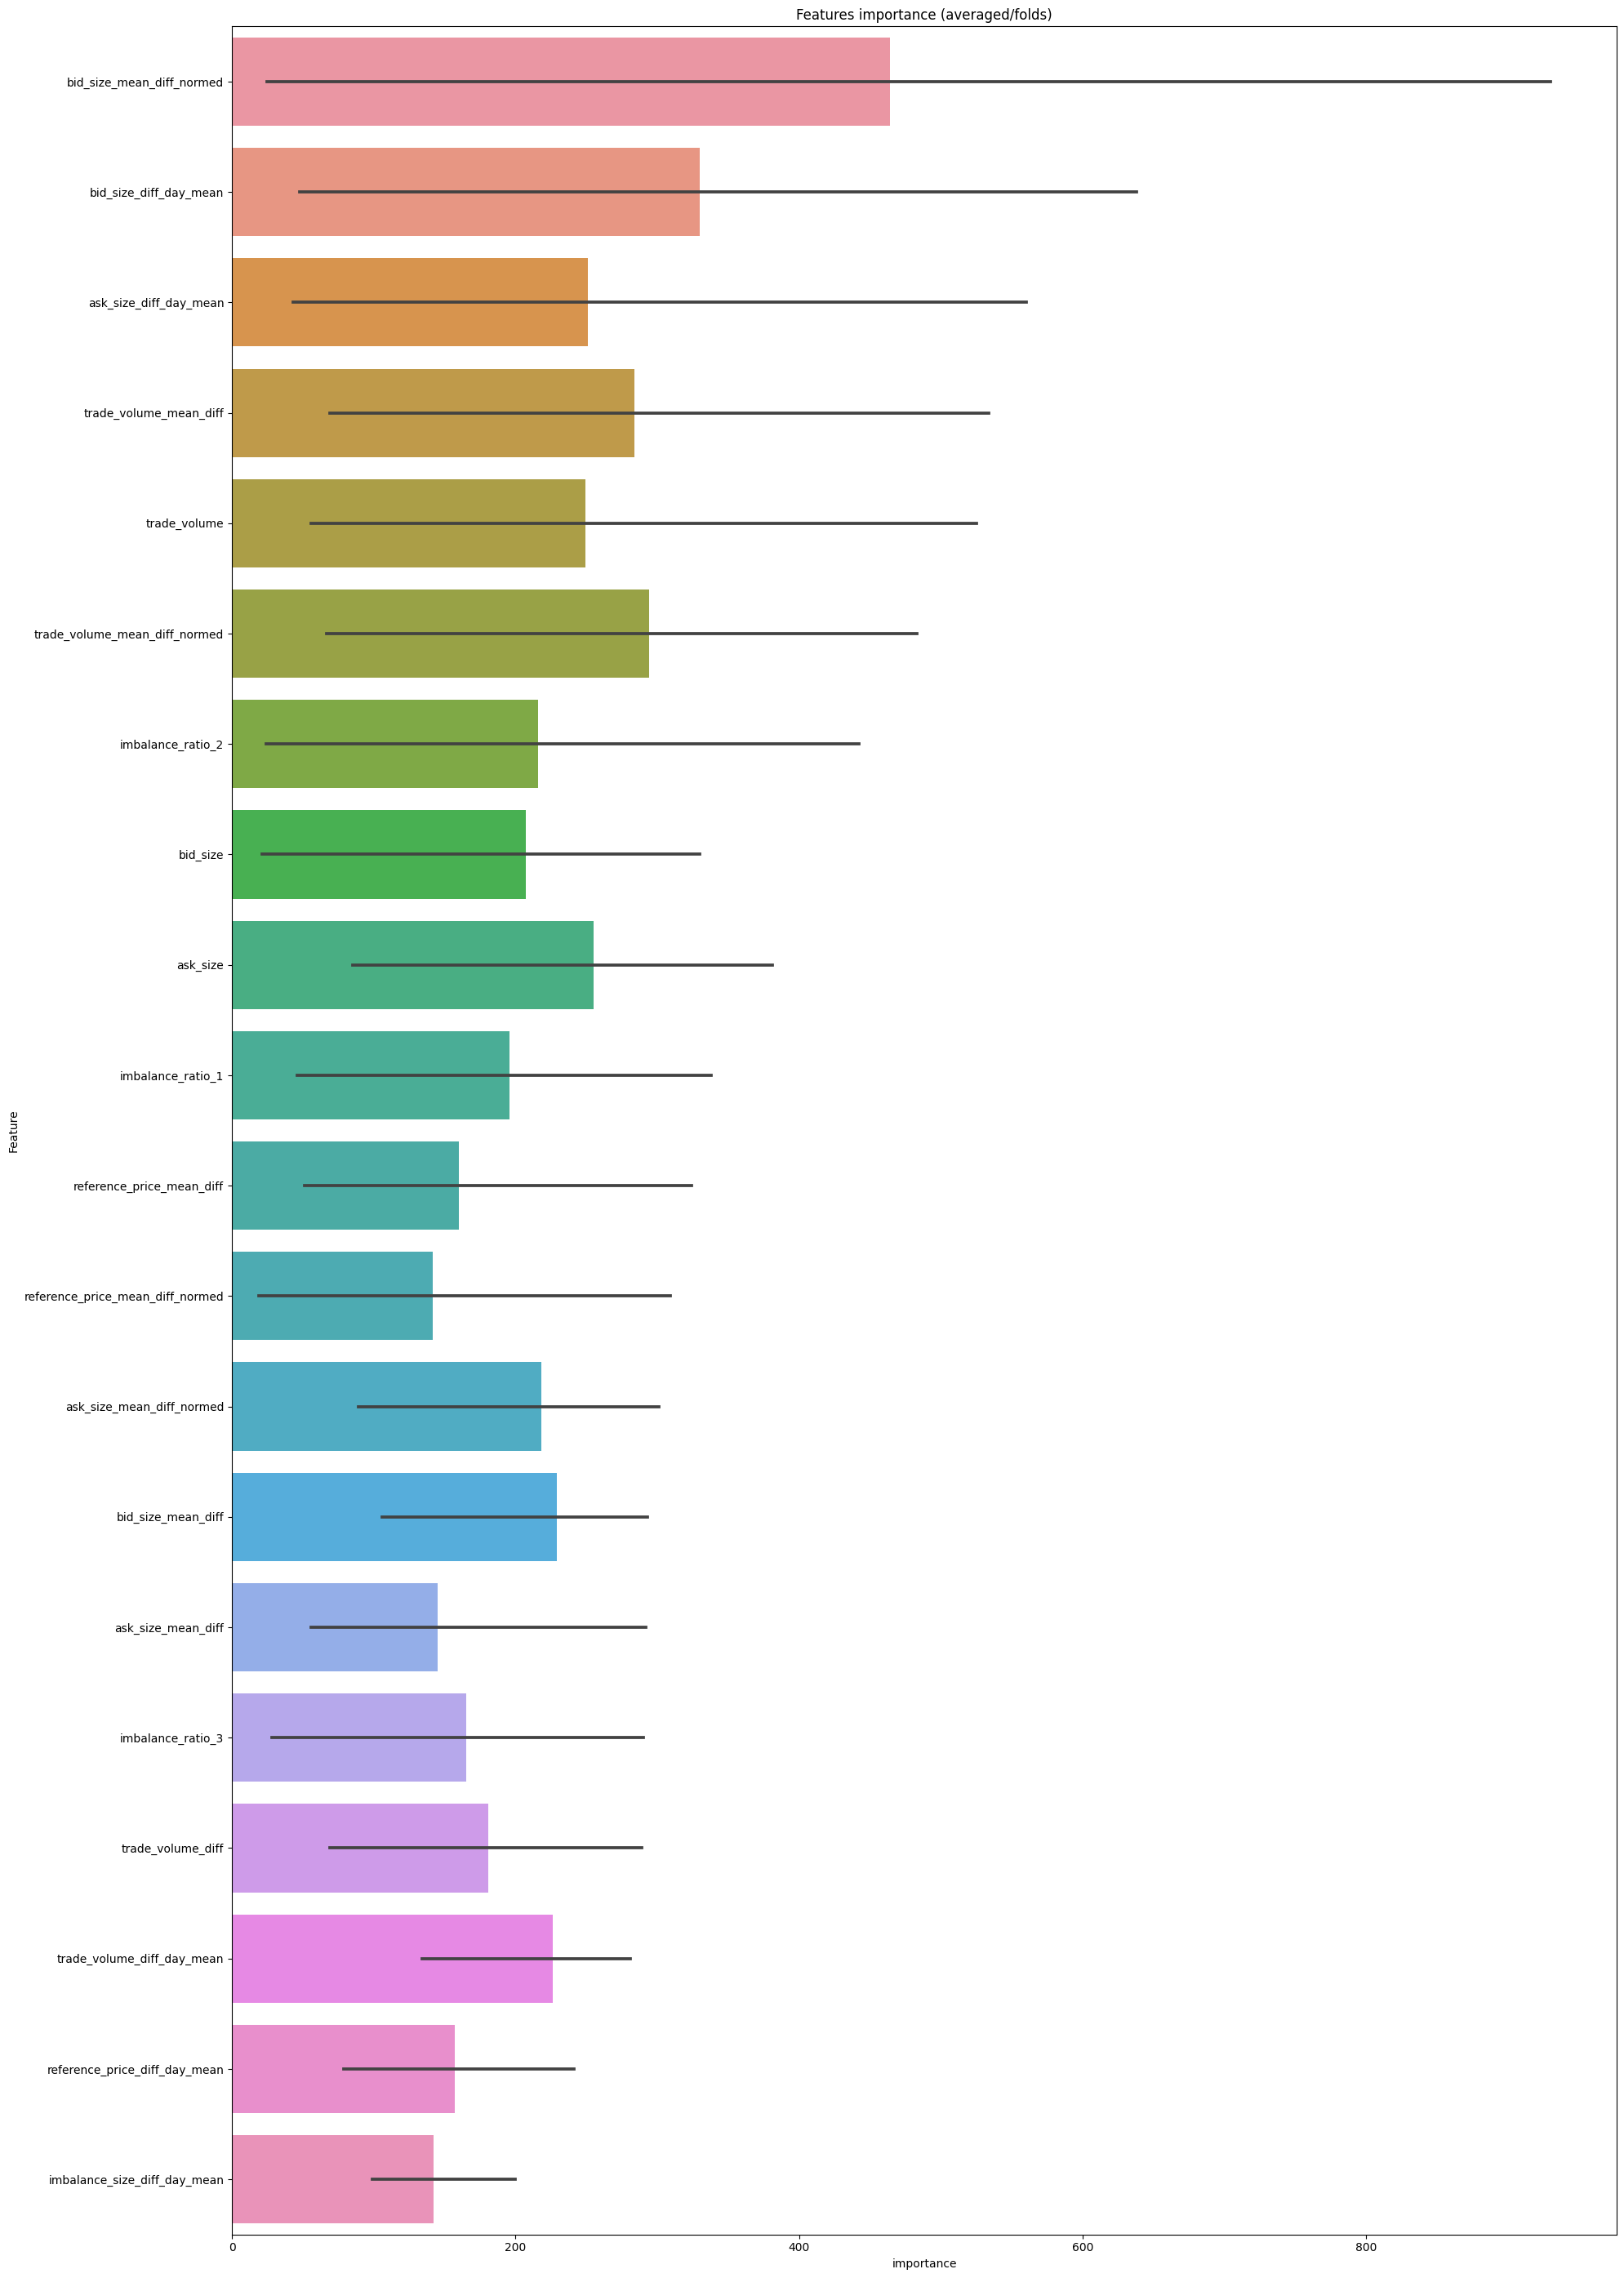

In [10]:
if is_train:
    # plot feature importance, feature selection
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:20].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    plt.figure(figsize=(20,28))
    sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
    plt.title('Features importance (averaged/folds)')
    plt.tight_layout()

# Inference mode

In [11]:
def zero_sum(prices, volumes):
    std_error = np.sqrt(volumes)
    step = np.sum(prices) / np.sum(std_error)
    out = prices - std_error * step
    return out

if is_infer:
    import optiver2023
    env = optiver2023.make_env()
    iter_test = env.iter_test()
    counter = 0
    y_min, y_max = -64, 64
    qps, predictions = [], []
    cache = pd.DataFrame()
    
    for (test, revealed_targets, sample_prediction) in iter_test:
        now_time = time.time()
        cache = pd.concat([cache, test], ignore_index=True, axis=0)
        if counter > 0:
            cache = cache.groupby(['stock_id']).tail(21).sort_values(by=['date_id', 'seconds_in_bucket', 'stock_id']).reset_index(drop=True)
        feat = feature_eng(cache)[-len(test):]

        # added after new API, reference: https://www.kaggle.com/competitions/optiver-trading-at-the-close/discussion/455690#2526672
#         if test.currently_scored.iloc[0]== False:
#             print('test.currently_scored')
#             sample_prediction['target'] = reg.predict(feat)
#             env.predict(sample_prediction)
#             counter += 1
#             qps.append(time.time() - now_time)
#             if counter % 10 == 0:
#                 print(counter, 'qps:', np.mean(qps))
#             continue

        feat = feat.drop(columns = ["currently_scored"])    
        # end of new codes for new API
        
        # Generate predictions for each model and calculate the weighted average
        lgb_predictions = reg.predict(feat)

        lgb_predictions = zero_sum(lgb_predictions, test['bid_size'] + test['ask_size'])
        clipped_predictions = np.clip(lgb_predictions, y_min, y_max)
        sample_prediction['target'] = clipped_predictions
        print(sample_prediction)
        env.predict(sample_prediction)
        counter += 1
        qps.append(time.time() - now_time)
        if counter % 10 == 0:
            print(counter, 'qps:', np.mean(qps))

    time_cost = 1.146 * np.mean(qps)
    print(f"The code will take approximately {np.round(time_cost, 4)} hours to reason about")
    

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
        row_id    target
0      478_0_0 -0.191524
1      478_0_1  0.681429
2      478_0_2  3.841621
3      478_0_3  1.444426
4      478_0_4 -4.814604
..         ...       ...
195  478_0_195  0.529808
196  478_0_196 -5.553544
197  478_0_197 -1.073567
198  478_0_198  6.948764
199  478_0_199 -4.908655

[200 rows x 2 columns]
         row_id    target
0      478_10_0  1.777221
1      478_10_1  7.897248
2      478_10_2  3.341120
3      478_10_3  2.383455
4      478_10_4 -8.464877
..          ...       ...
195  478_10_195 -4.292776
196  478_10_196  8.949669
197  478_10_197  1.726254
198  478_10_198  3.287972
199  478_10_199 -0.583170

[200 rows x 2 columns]
         row_id    target
0      478_20_0  0.951060
1      478_20_1  5.435344
2      478_20_2  3.151090
3      478_20_3 -3.081616
4      478_20_4 -6.434920
..          ...       ...
195  478_20_195  2.880928
196  47